# 1. Overview

This notebook will explore the relationships among fluorescent channels in collman15v2 dataset. It will examine and compare the integrated intensity of three regions:
  1. Region that has voxels associated with an annotation
  2. Region that has voxels that are not associated with an annotation, but around voxels that associate with an annotation
  3. Region that is not associated with any annotation.

For each feature channel, a $11 \times 11 \times 9$ cube is taken around the centroid of each annotation in annotation channel. This assumes that each voxel in fluorescent space is $80nm \times 80nm \times 70nm$, which translates to about $396\times396\times9$ voxels per cube.

# 2. Feature Definition

Let $V$ be an 11x11x9 volume. For every pixel $i \in V$, let $b_i$ denote the brightness of pixel $i$.

  * Integrated intensity $F_0$ = $\sum_{i\in V} b_i$

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.measure import block_reduce, moments

In [2]:
file = np.load('collman15v2.npz')

In [3]:
channels = file.files
channels

['annotation',
 'EM25K',
 'GABA488',
 'GAD647',
 'gephyrin594',
 'GS594',
 'MBP488',
 'NR1594',
 'PSD95_488',
 'Synapsin647',
 'VGluT1_647',
 'DAPI1st']

In [4]:
data = {k: v for k, v in file.iteritems()}

In [5]:
def calculate_centroid(arr, label):
    z = []
    y = []
    x = []
    
    arr = np.multiply(arr==label, arr)
    
    for i, arr_slice in enumerate(arr):
        if np.isin(label, arr_slice):
            m = moments(arr_slice, order=1)
            cr = m[0, 1] / m[0, 0]
            cc = m[1, 0] / m[0, 0]
            x.append(cc)
            y.append(cr)
            z.append(i)
            
    return (np.mean(z), np.mean(y), np.mean(x))

In [6]:
annotation_uniques = np.unique(data['annotation'])
annotation_uniques = np.extract(annotation_uniques > 0, annotation_uniques)

In [10]:
centroids = []
for i in annotation_uniques:
    centroids.append(calculate_centroid(data['annotation'], i))
    print('Finished Calculating: ', i)

Finished Calculating:  1
Finished Calculating:  2
Finished Calculating:  3
Finished Calculating:  4
Finished Calculating:  5
Finished Calculating:  6
Finished Calculating:  7
Finished Calculating:  8
Finished Calculating:  9
Finished Calculating:  10
Finished Calculating:  11
Finished Calculating:  12
Finished Calculating:  13
Finished Calculating:  14
Finished Calculating:  15
Finished Calculating:  16
Finished Calculating:  17
Finished Calculating:  19
Finished Calculating:  20
Finished Calculating:  21
Finished Calculating:  22
Finished Calculating:  23
Finished Calculating:  24
Finished Calculating:  25
Finished Calculating:  26
Finished Calculating:  27
Finished Calculating:  28
Finished Calculating:  29
Finished Calculating:  30
Finished Calculating:  31
Finished Calculating:  32
Finished Calculating:  33
Finished Calculating:  34
Finished Calculating:  35
Finished Calculating:  36
Finished Calculating:  37
Finished Calculating:  38
Finished Calculating:  39
Finished Calculating:

In [6]:
centroids = np.load('centroids.npy')

In [7]:
centroids[0]

array([  1.00000000e+00,   1.50000000e+00,   3.20588780e+03,
         3.56552938e+03])

In [8]:
def calculate_dimensions(centroid, z_dim, y_dim, x_dim):
    z_dim = z_dim / 2
    y_dim = y_dim / 2
    x_dim = x_dim / 2

    #Max dimensions of collman15v2 data
    z_max = 27
    y_max = 4518
    x_max = 6306
    
    z_range = np.around([centroid[0] - z_dim if centroid[0] - z_dim > 0 else 0, 
            centroid[0] + z_dim if centroid[0] + z_dim < z_max else z_max]).astype(int)
    y_range = np.around([centroid[1] - y_dim if centroid[1] - y_dim > 0 else 0, 
            centroid[1] + y_dim if centroid[1] + y_dim < y_max else y_max]).astype(int)
    x_range = np.around([centroid[2] - x_dim if centroid[2] - x_dim > 0 else 0, 
            centroid[2] + x_dim if centroid[2] + x_dim < x_max else x_max]).astype(int)

    return z_range, y_range, x_range

In [9]:
def calculate_f0(annotation, channel, _):
    synapse = np.sum(np.multiply(channel, annotation > 0))
    around_synapse = np.sum(np.multiply(channel, annotation == 0))
    
    return synapse, around_synapse

In [10]:
def calculate_f0_reduced(annotation, channel, block_size):
    """
    This method calculates the f0 after reducing the 396x396x9 cube into 11x11x9 cube.
    """
    annotation = block_reduce(annotation, block_size, np.mean)
    channel = block_reduce(channel, block_size, np.mean)
    
    synapse = np.sum(np.multiply(annotation > 0, channel))
    around_synapse = np.sum(np.multiply(annotation == 0, channel))

    return synapse, around_synapse

In [121]:
def f0(centroids, channel_list, data, reduced=False):
    """
    Return list of all f0 given a list of centroid and annotations
    """
    synapse_f0 = []
    around_synapse_f0 = []
    
    for centroid in centroids:
        temp_syn = [centroid[0]]
        temp_around = [centroid[0]]
        
        z, y, x, = calculate_dimensions(centroid[1:], 9, 396, 396)
        
        for channel in channel_list:
            if channel not in ['annotation', 'EM25K']:
                channel_slice = data[channel][z[0]:z[1], y[0]:y[1], x[0]:x[1]]
                annotation_slice = data['annotation'][z[0]:z[1], y[0]:y[1], x[0]:x[1]]
                if reduced:
                    a, b = calculate_f0_reduced(annotation_slice, channel_slice, (1, 36, 36))
                else:
                    a, b = calculate_f0(annotation_slice, channel_slice, (1, 36, 36))
                temp_syn.append(a)
                temp_around.append(b)
                
        synapse_f0.append(temp_syn)
        around_synapse_f0.append(temp_around)
    
    return synapse_f0, around_synapse_f0

In [12]:
a, b = f0(centroids, channels, data)

In [134]:
columns = [ 'Synapsin647',
            'VGluT1_647',
            'PSD95_488',
            'GS594',
            'NR1594',
            'GAD647',
            'GABA488',
            'gephyrin594',
            'MBP488',
            'DAPI1st', 
            'location']

In [15]:
labels = ['synapse'] + channels[2:]
location_labels = ['on_synapse'] * 236 + ['around_synapse'] * 236

In [13]:
all_df = pd.DataFrame(a, columns=labels).append(pd.DataFrame(b, columns=labels))

all_df['location'] = location_labels

all_df.head()

In [17]:
all_df.to_csv('data.csv', index=False)

In [124]:
all_df = pd.read_csv('data.csv')

## Relationship between on_synapse and around_synapse regions

  * Blue = synapse
  * Green = around synapse

In [13]:
sns.set_context("paper", rc={"axes.labelsize": 23})

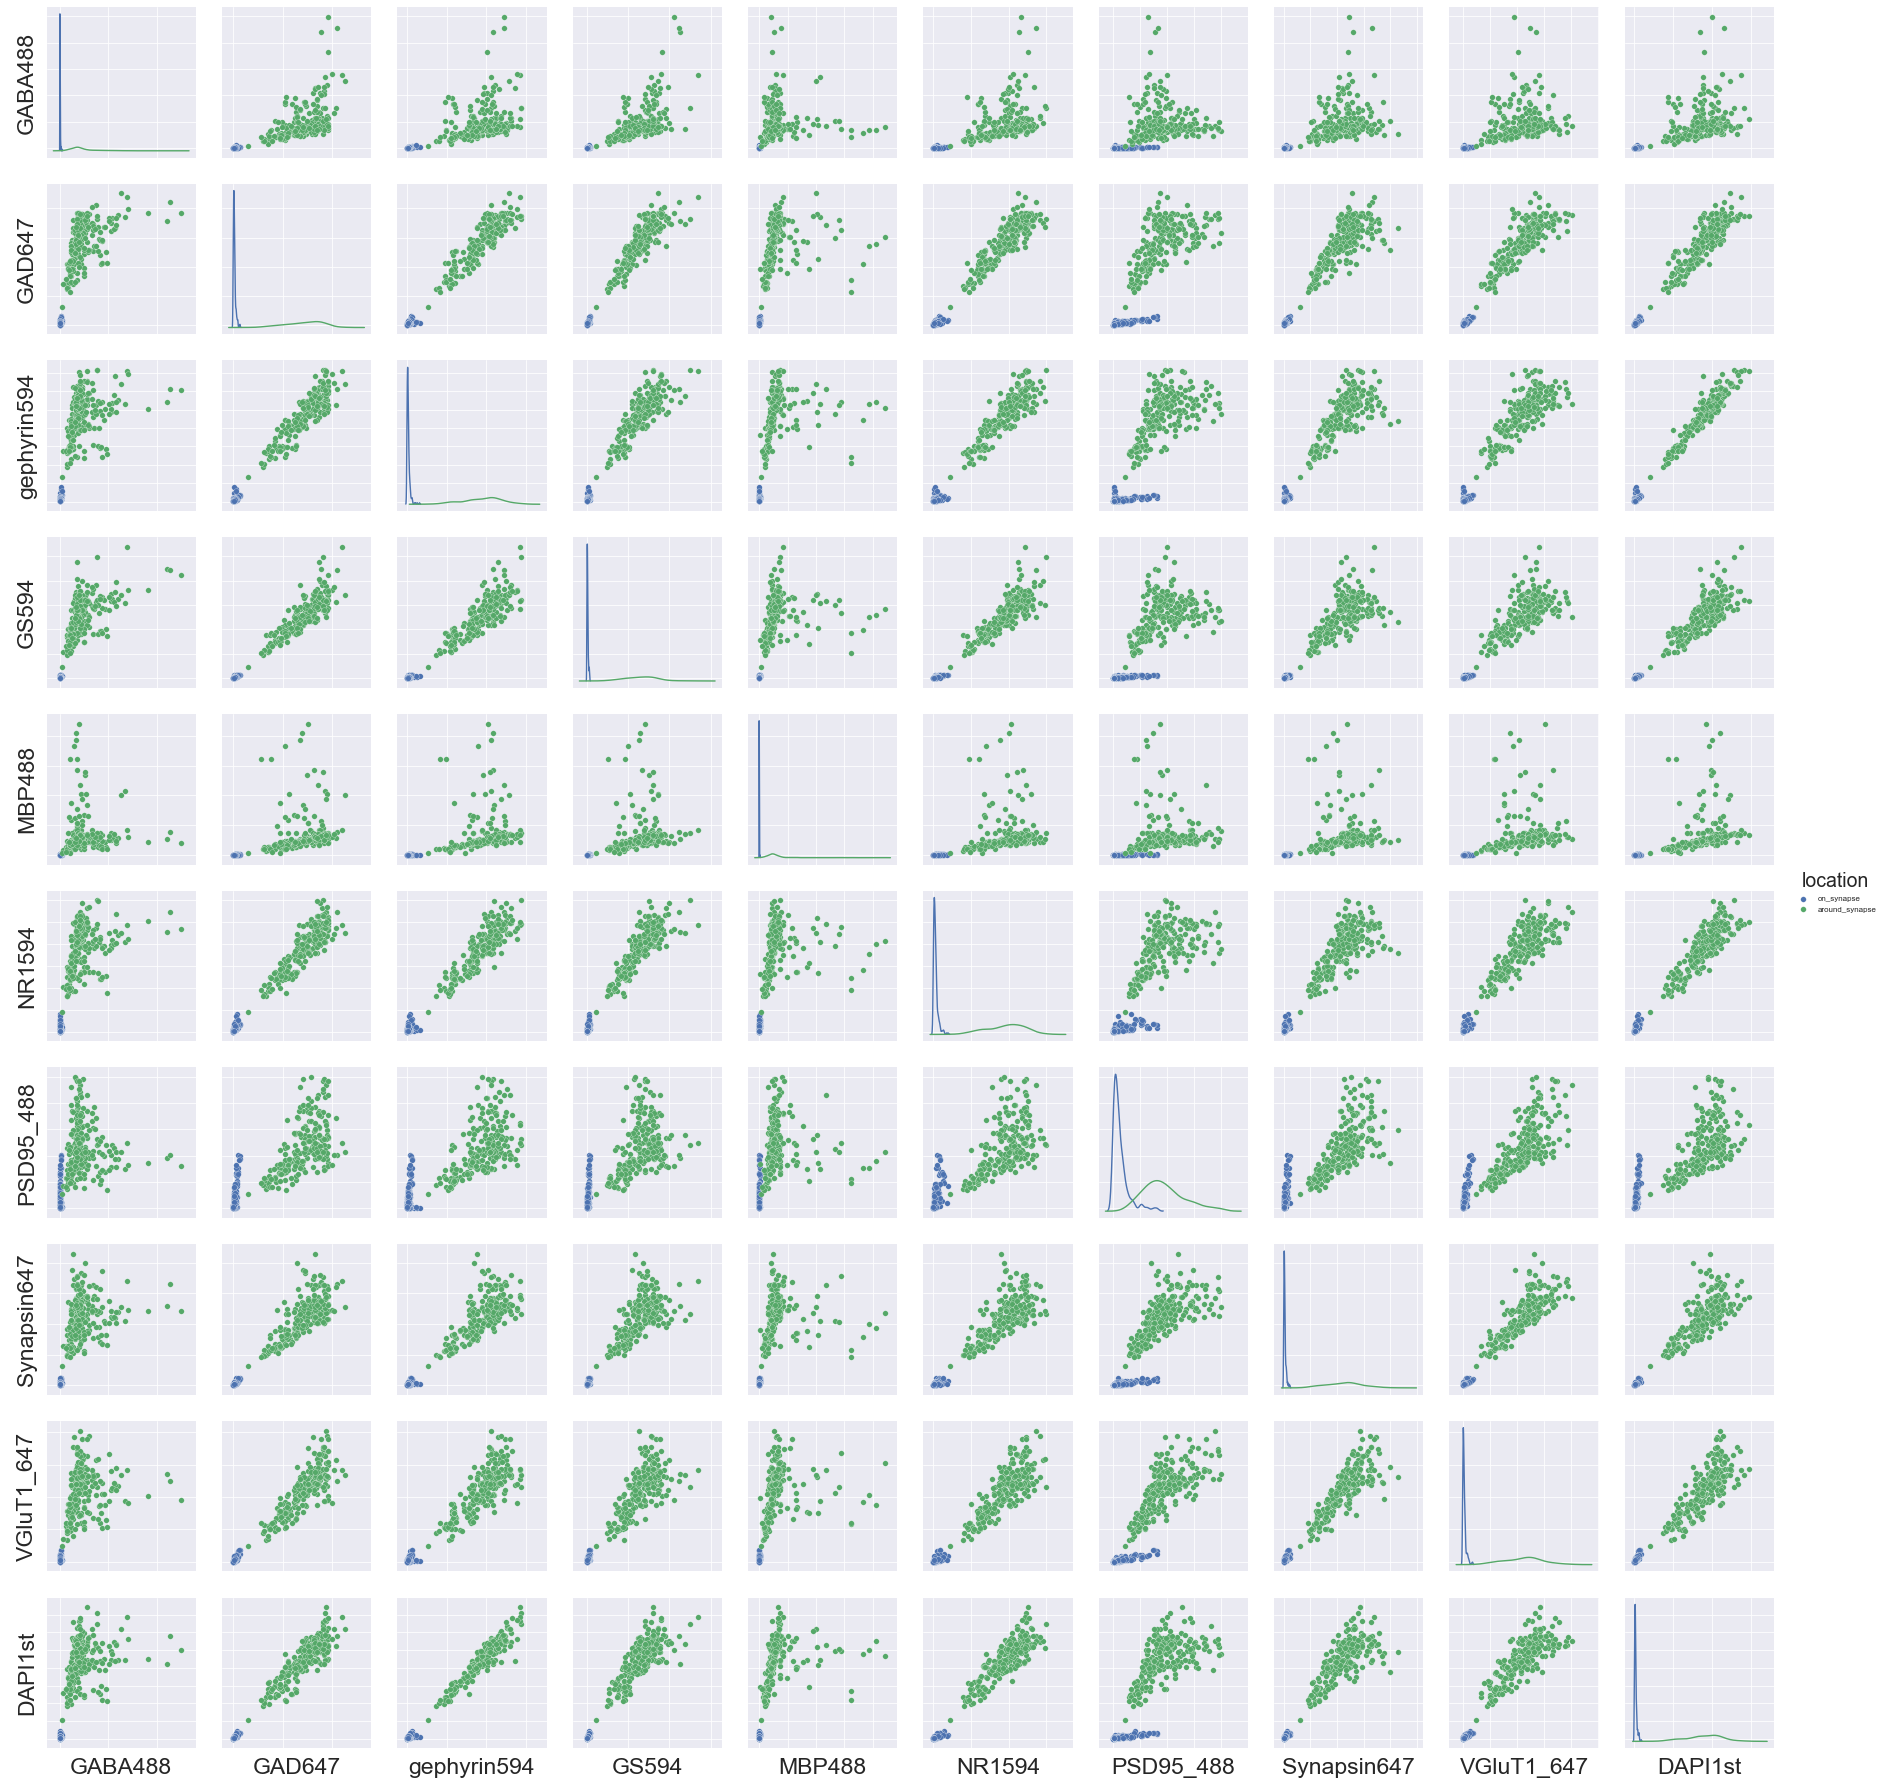

In [16]:
g = sns.pairplot(all_df[columns], hue="location", diag_kind='kde')
g.set(xticklabels=[], yticklabels=[])
g.fig

In [17]:
log_transformed_df = all_df[
['GABA488',
 'GAD647',
 'gephyrin594',
 'GS594',
 'MBP488',
 'NR1594',
 'PSD95_488',
 'Synapsin647',
 'VGluT1_647',
 'DAPI1st']].transform(lambda x: np.log(x))

log_transformed_df['location'] = all_df['location']

/Users/jaewonc78/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


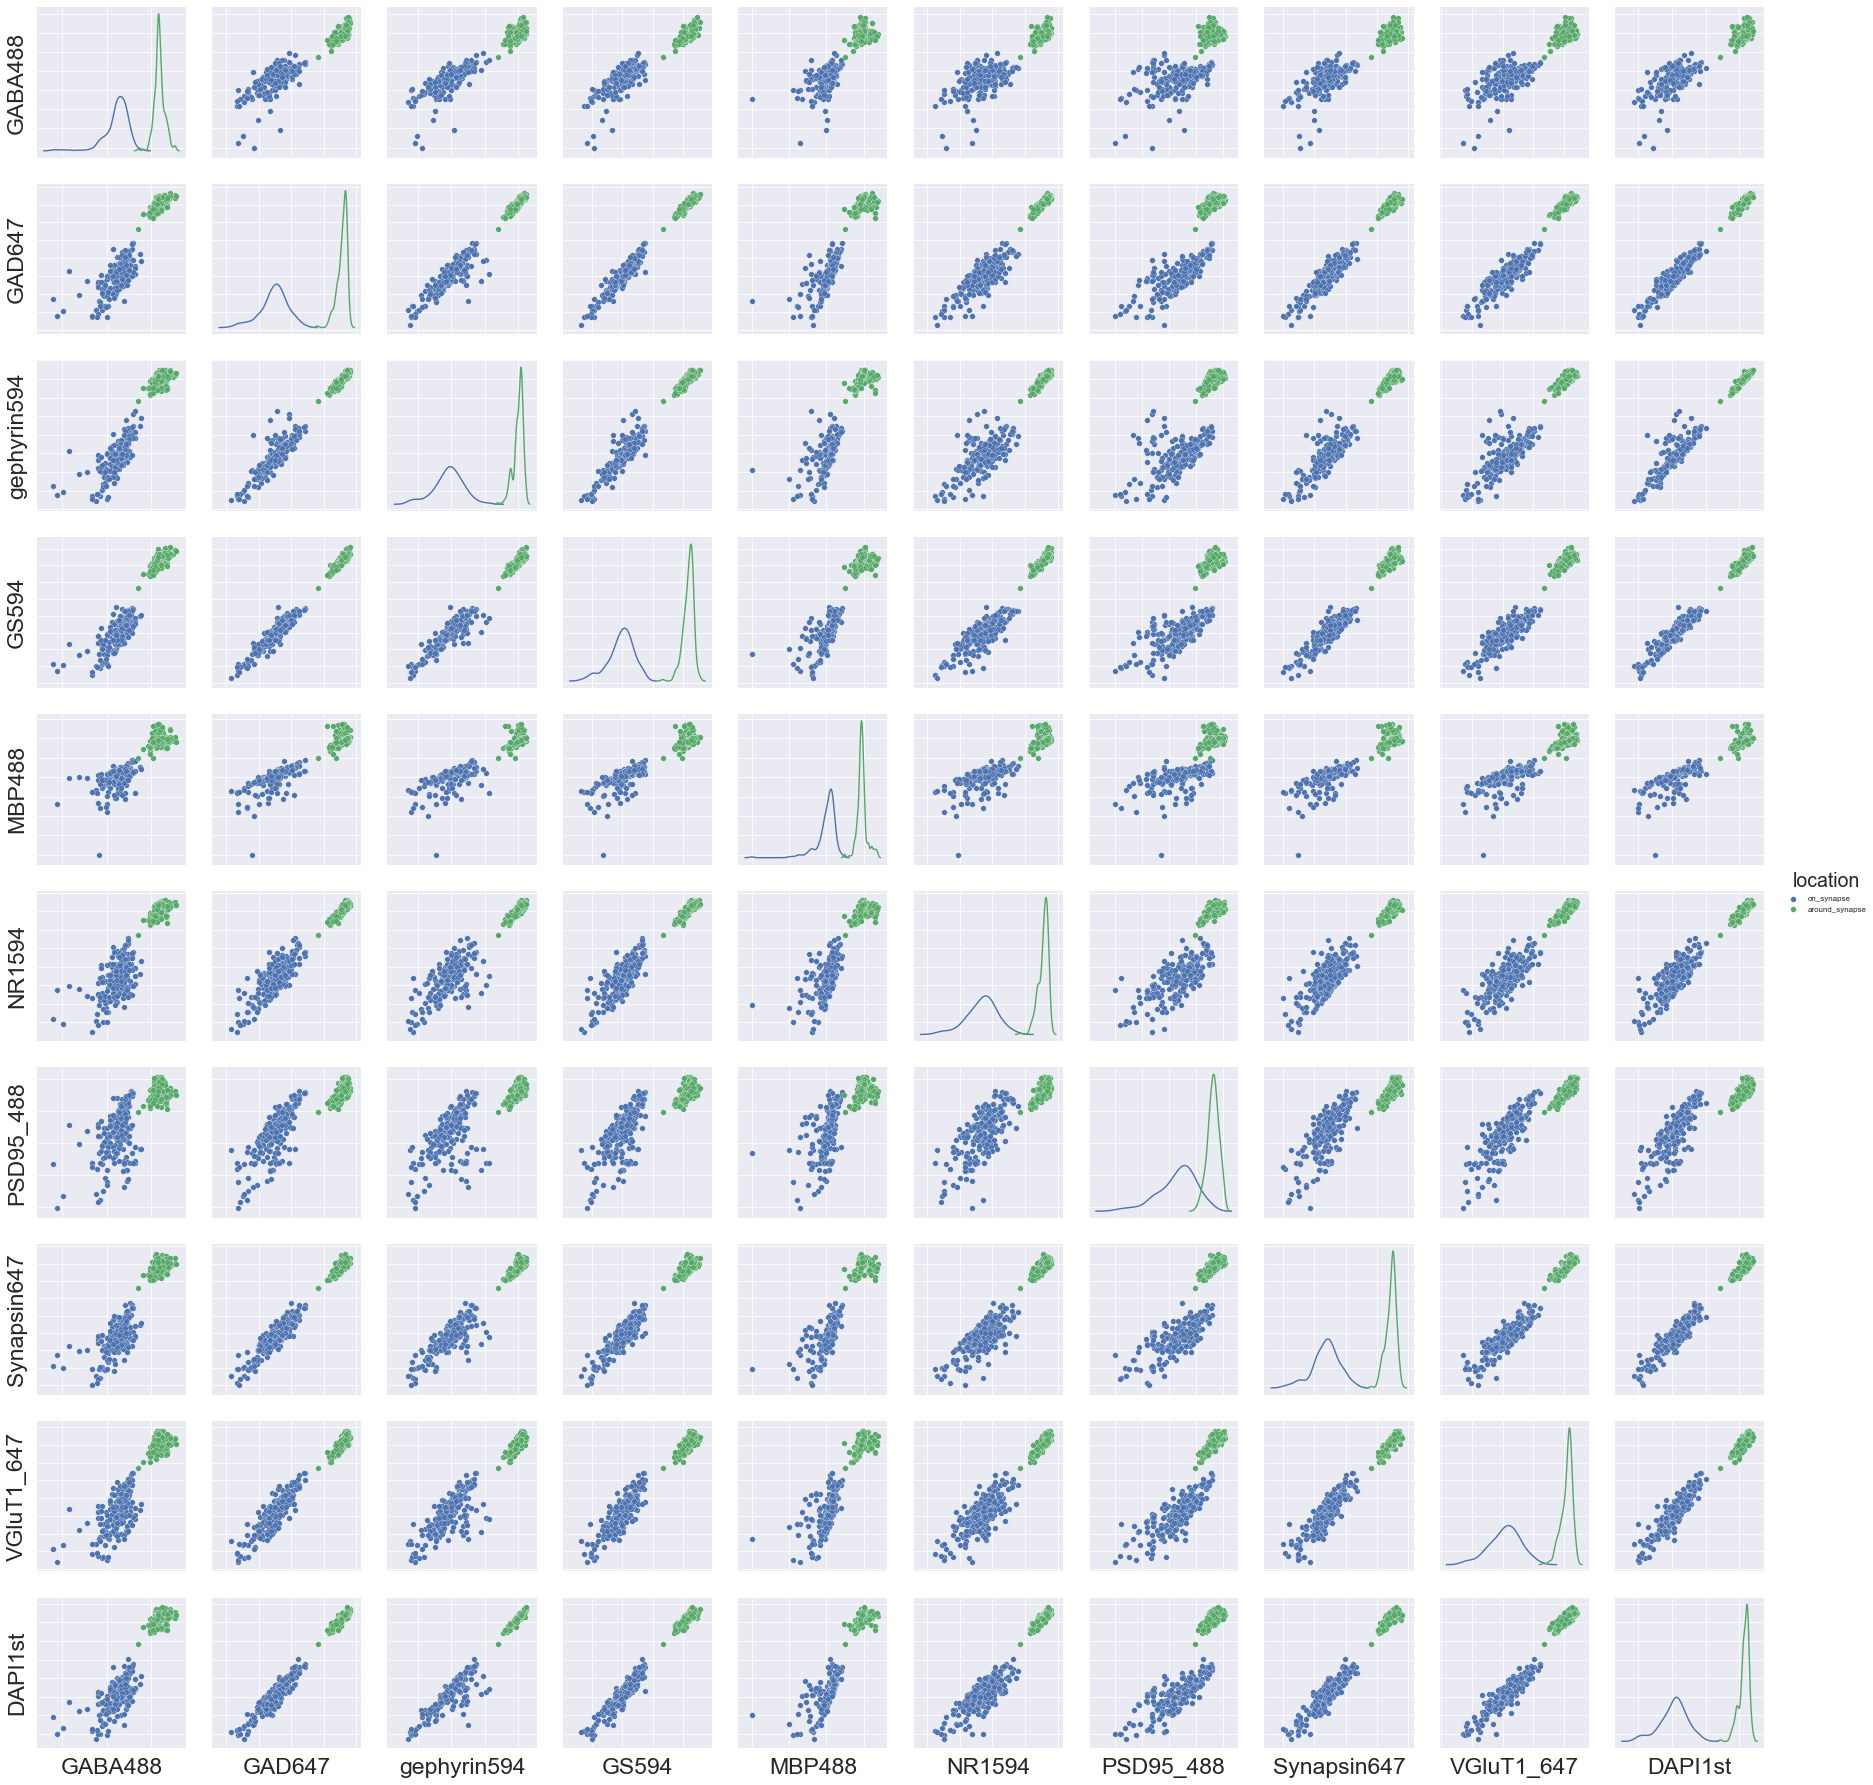

In [19]:
h = sns.pairplot(log_transformed_df[columns], hue="location", diag_kind='kde')
h.set(xticklabels=[], yticklabels=[])
h.fig

In [20]:
reduced_df = pd.read_csv('data_block_reduced.csv')
reduced_df.head()

synapse     GABA488       GAD647  gephyrin594       GS594     MBP488  \
0        1   45.289352  1442.101852   279.580247  273.657407  85.596451   
1        2   56.072531   898.182099   261.004630  234.016204  56.438272   
2        3    2.866512   179.957562    58.223765   67.429784   0.000000   
3        4  107.237654   770.812500   222.314815  204.767747  32.628086   
4        5   58.469136   604.423611   280.493056  201.173611  70.493827   

       NR1594    PSD95_488  Synapsin647  VGluT1_647      DAPI1st    location  
0  137.943673  1257.960648   727.141975  450.688272  2771.977623  on_synapse  
1  240.129630  1451.321759   678.551698  210.288580  2821.550926  on_synapse  
2   20.592593    16.215278   143.695988  100.337191   591.666667  on_synapse  
3  147.530093   623.230710   499.150463  329.557870  2449.277006  on_synapse  
4  186.238426   280.224537   591.067130  186.085648  2815.867284  on_synapse

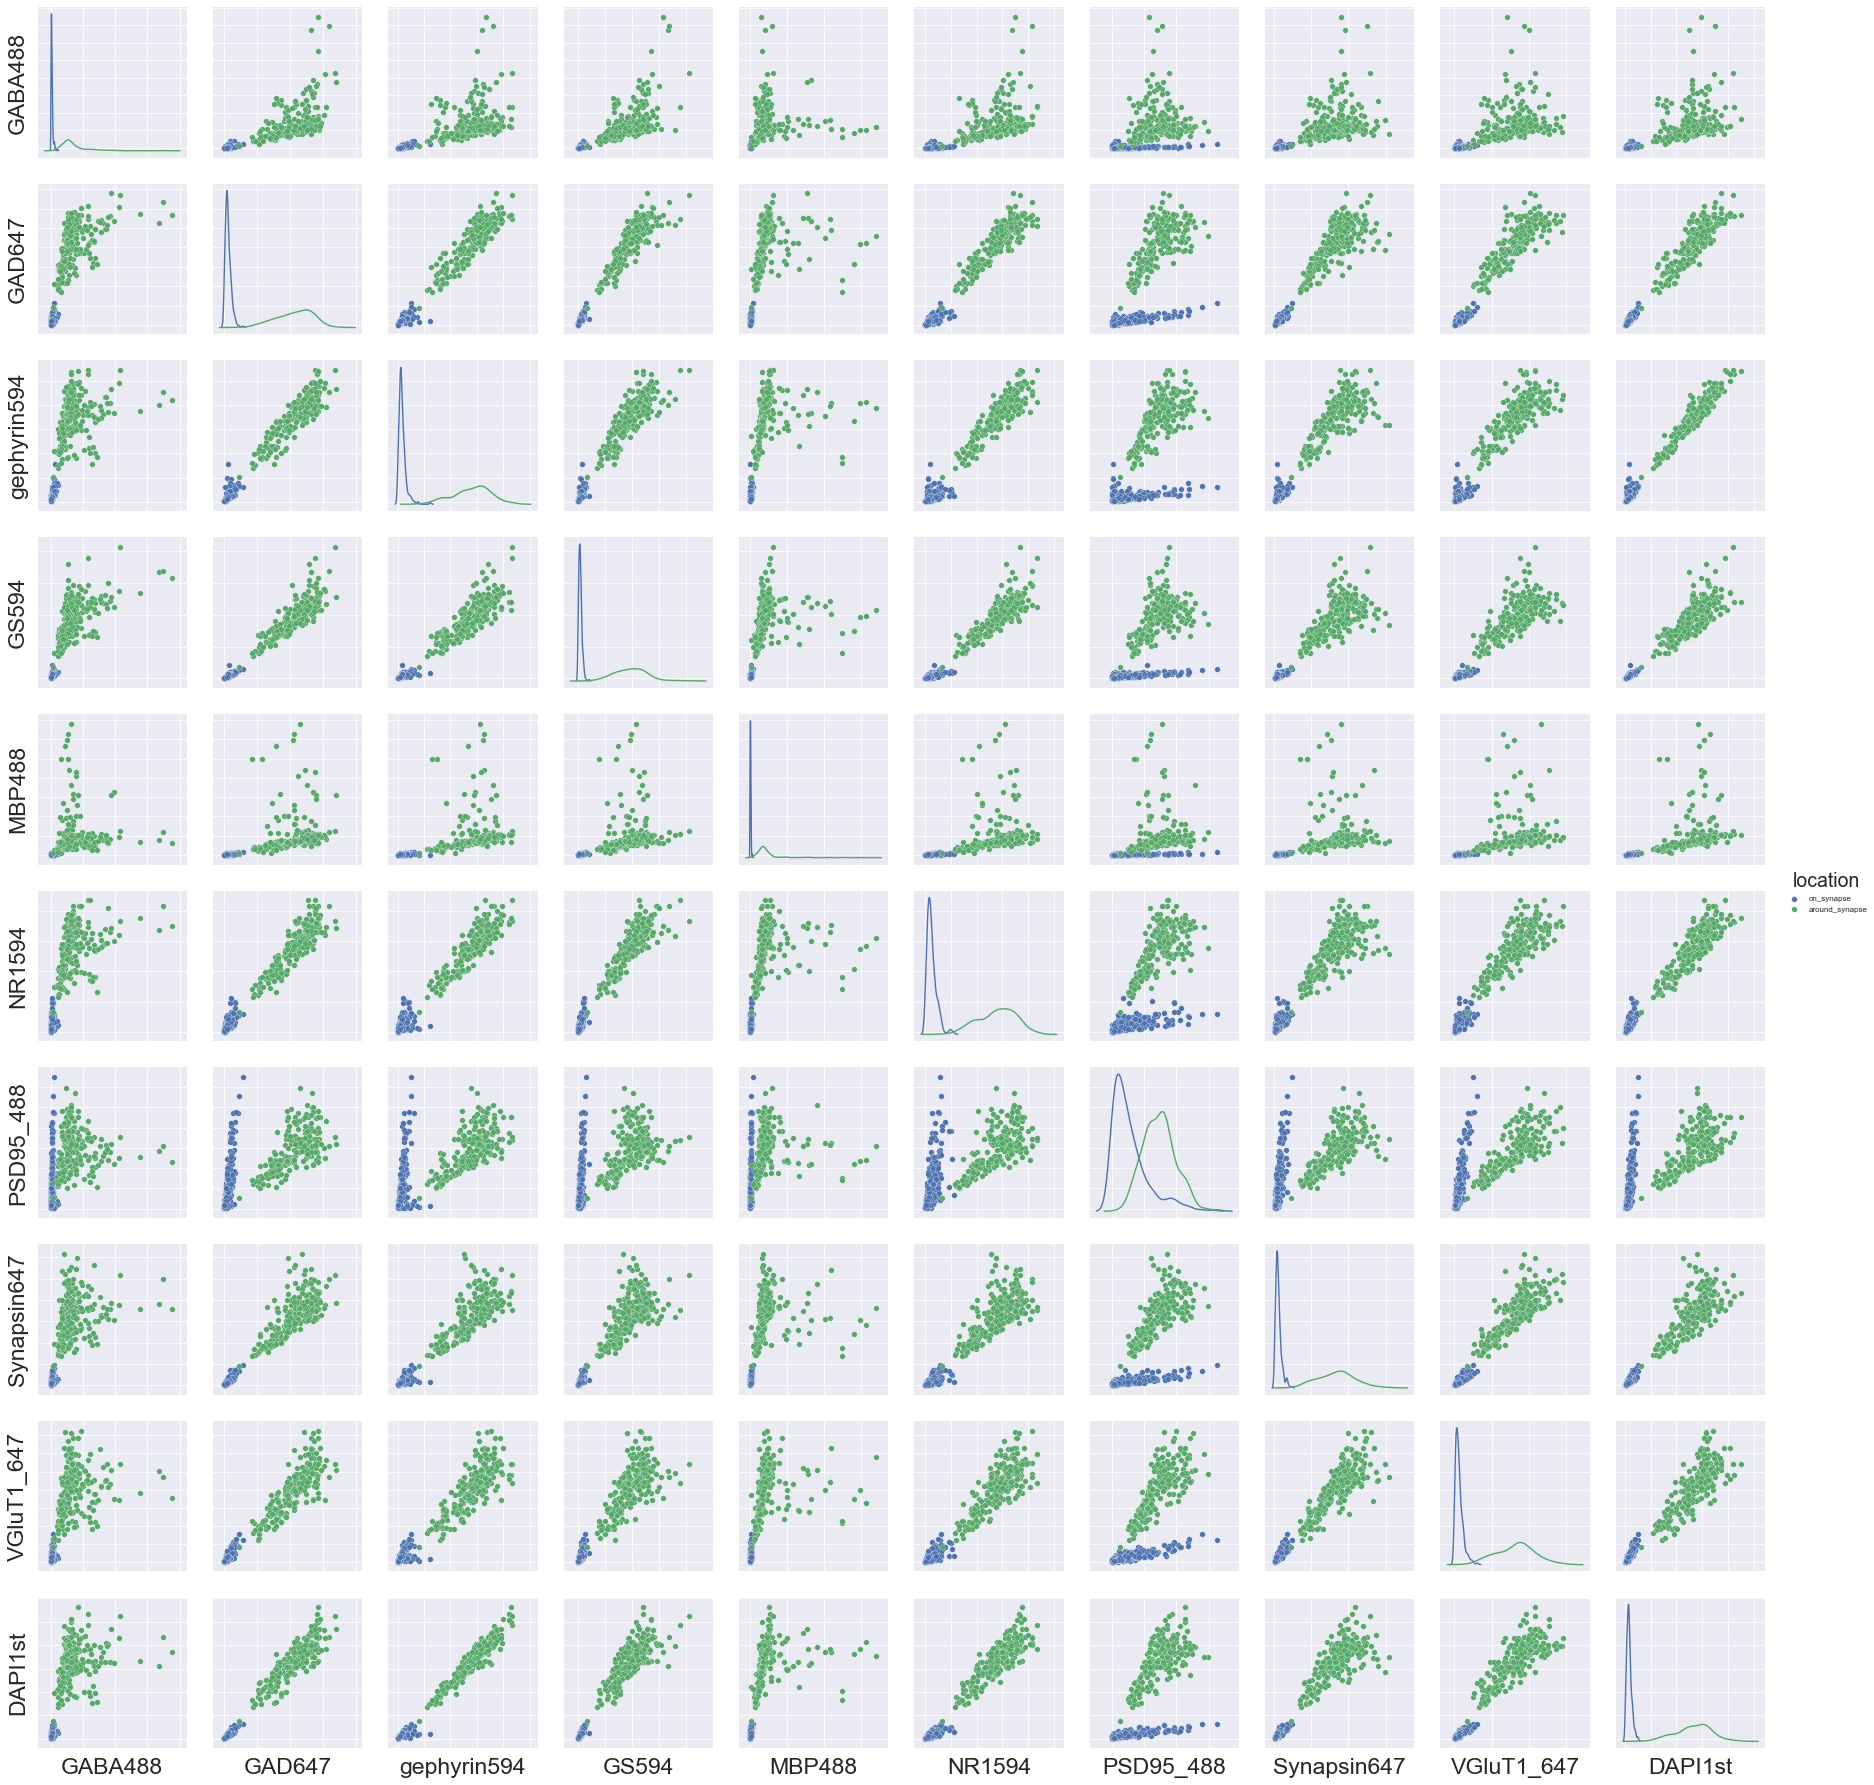

In [21]:
reduced_g = sns.pairplot(reduced_df[columns], hue="location", diag_kind='kde')
reduced_g.set(xticklabels=[], yticklabels=[])
reduced_g.fig

In [22]:
log_transformed_reduced_df = reduced_df[
['GABA488',
 'GAD647',
 'gephyrin594',
 'GS594',
 'MBP488',
 'NR1594',
 'PSD95_488',
 'Synapsin647',
 'VGluT1_647',
 'DAPI1st']].transform(lambda x: np.log(x))
log_transformed_reduced_df['location'] = reduced_df['location']

/Users/jaewonc78/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


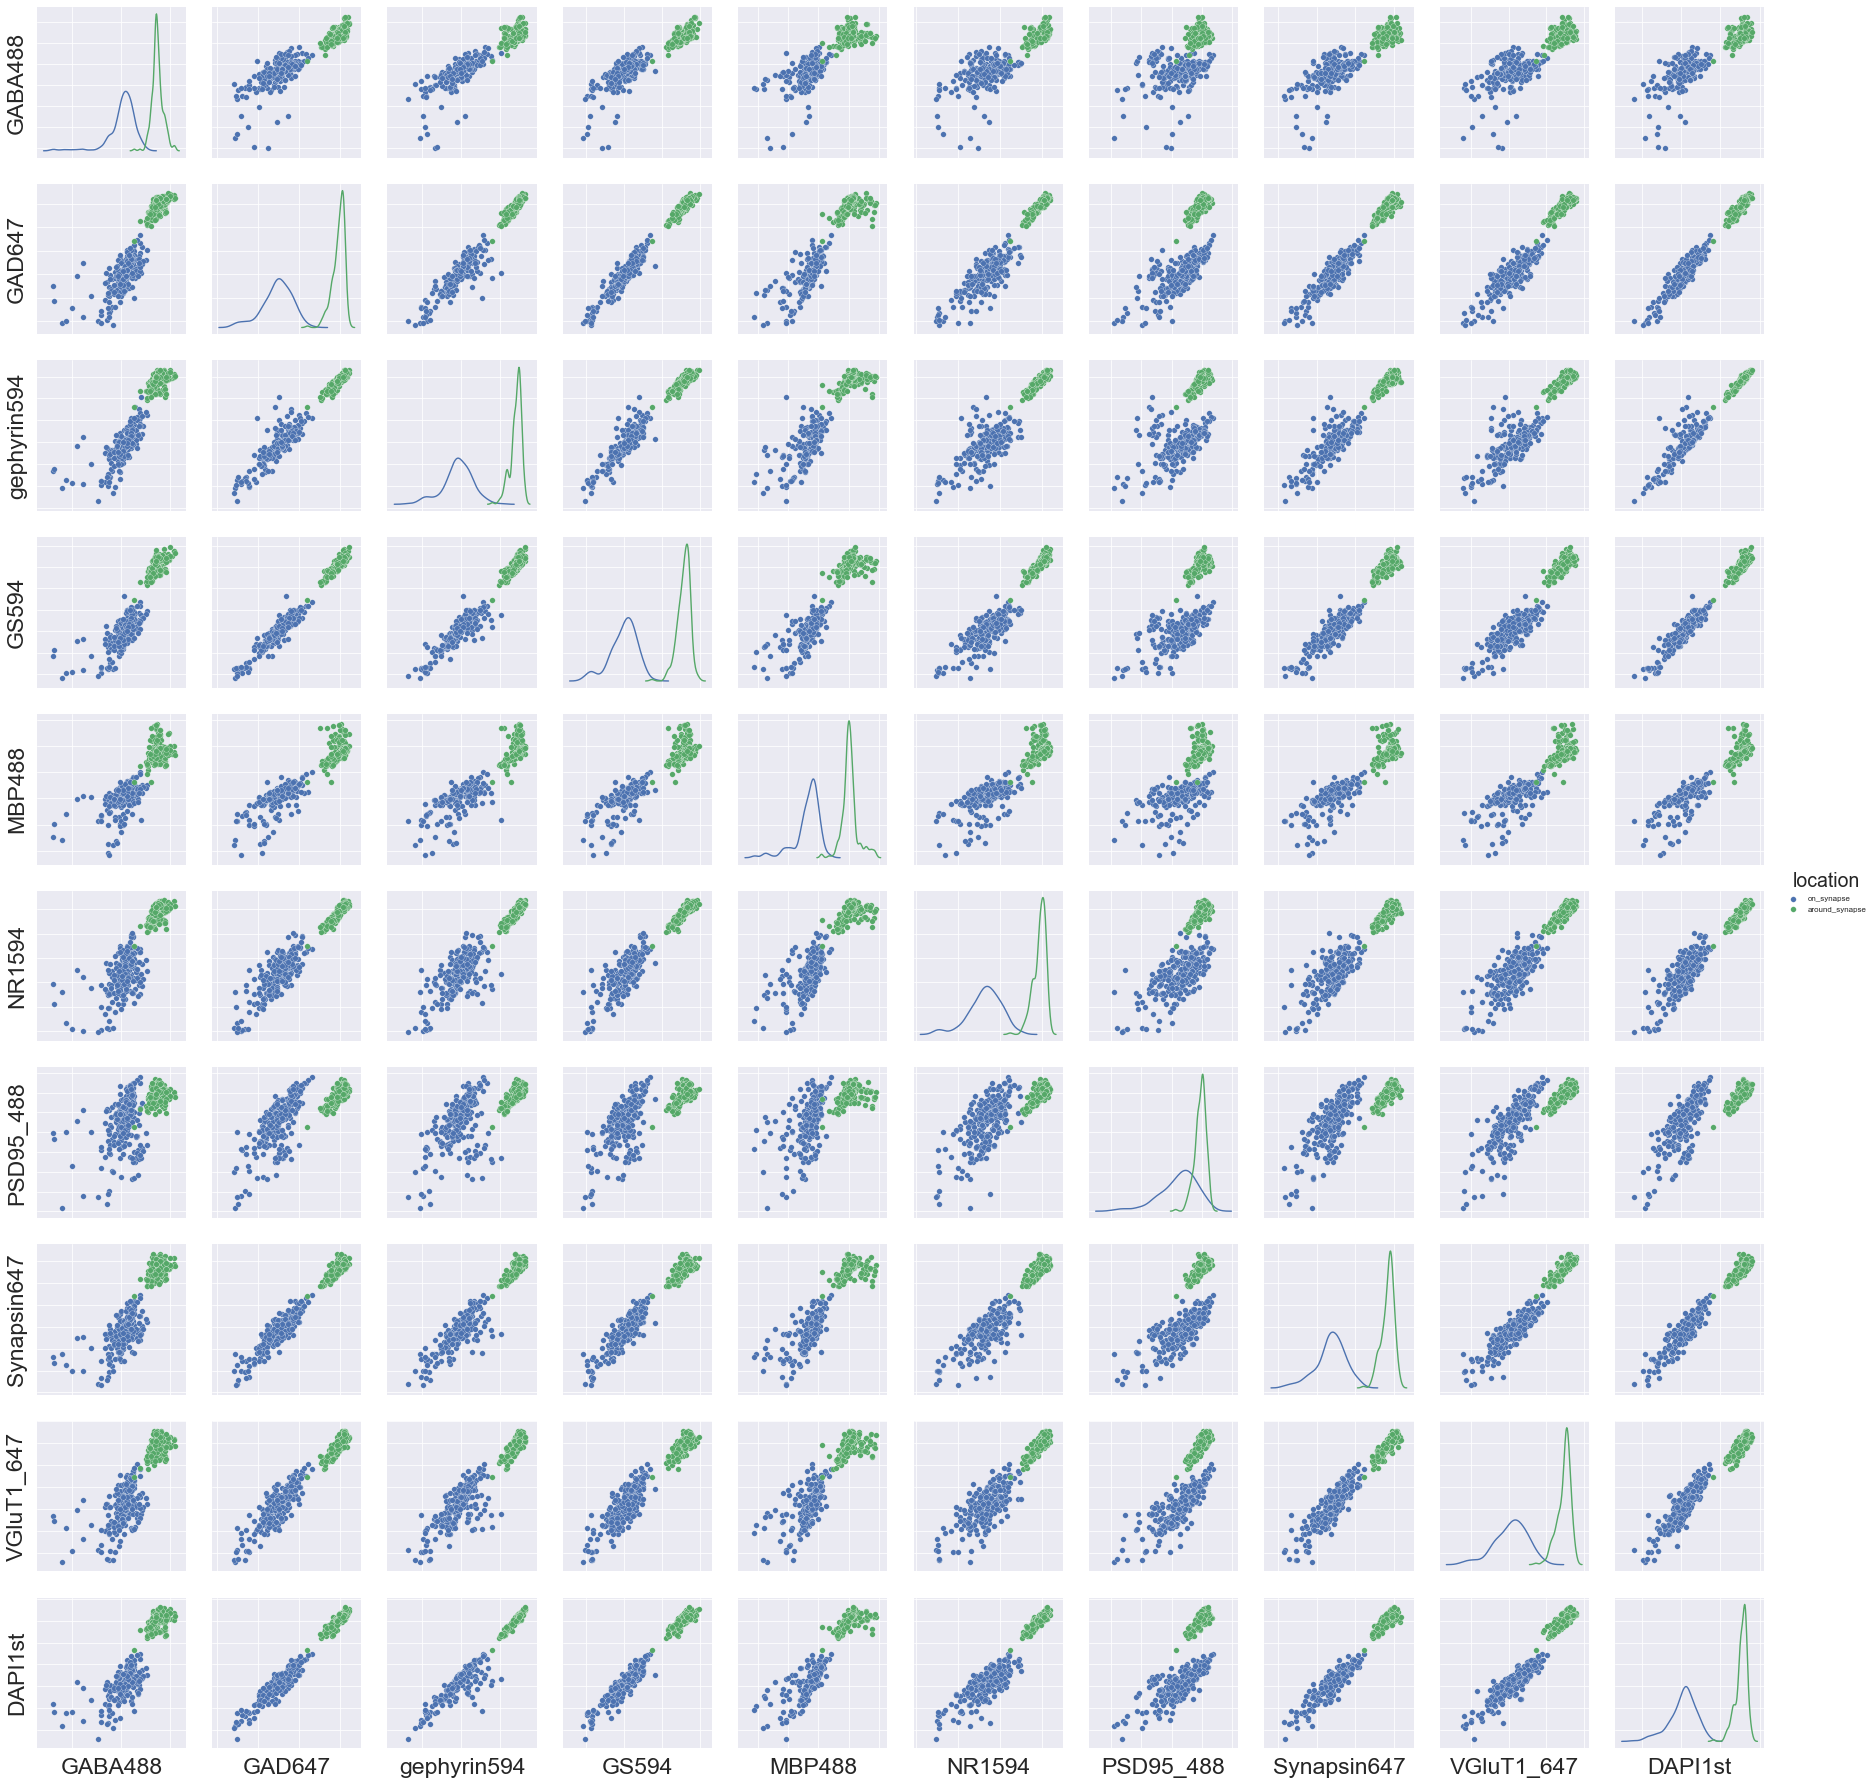

In [23]:
reduced_h = sns.pairplot(log_transformed_reduced_df[columns], hue="location", diag_kind='kde')
reduced_h.set(xticklabels=[], yticklabels=[])
reduced_h.fig

In [80]:
def get_random_non_synapse(mask, annotation):    
    z = np.random.randint(0, 27, 20)
    y = np.random.randint(0, 4518, 20)
    x = np.random.randint(0, 6306, 20)

    non_synapses = []
    
    for point in itertools.product(z, y, x):
        if mask[point]:
            z_range, y_range, x_range = calculate_dimensions(point, 9, 396, 396)
            if np.sum(annotation[z_range[0]:z_range[1], 
                                 y_range[0]:y_range[1], 
                                 x_range[0]:x_range[1]]) == 0:
                non_synapses.append(point)

    return non_synapses

In [77]:
mask = data['EM25K'] > 0

In [126]:
points = np.array(get_random_non_synapse(mask, data['annotation']))
points = np.append(np.zeros((len(points), 1)), points, axis=1)

In [127]:
random_non_synapse_centroids = points[np.random.choice(range(len(points)), size=200, replace=False)]

In [128]:
a, b = f0(random_non_synapse_centroids, channels, data)

In [129]:
non_synapse_df = pd.DataFrame(b, columns=labels)
non_synapse_df['location'] = 'non_synapse'

In [130]:
non_synapse_df = all_df.append(non_synapse_df)

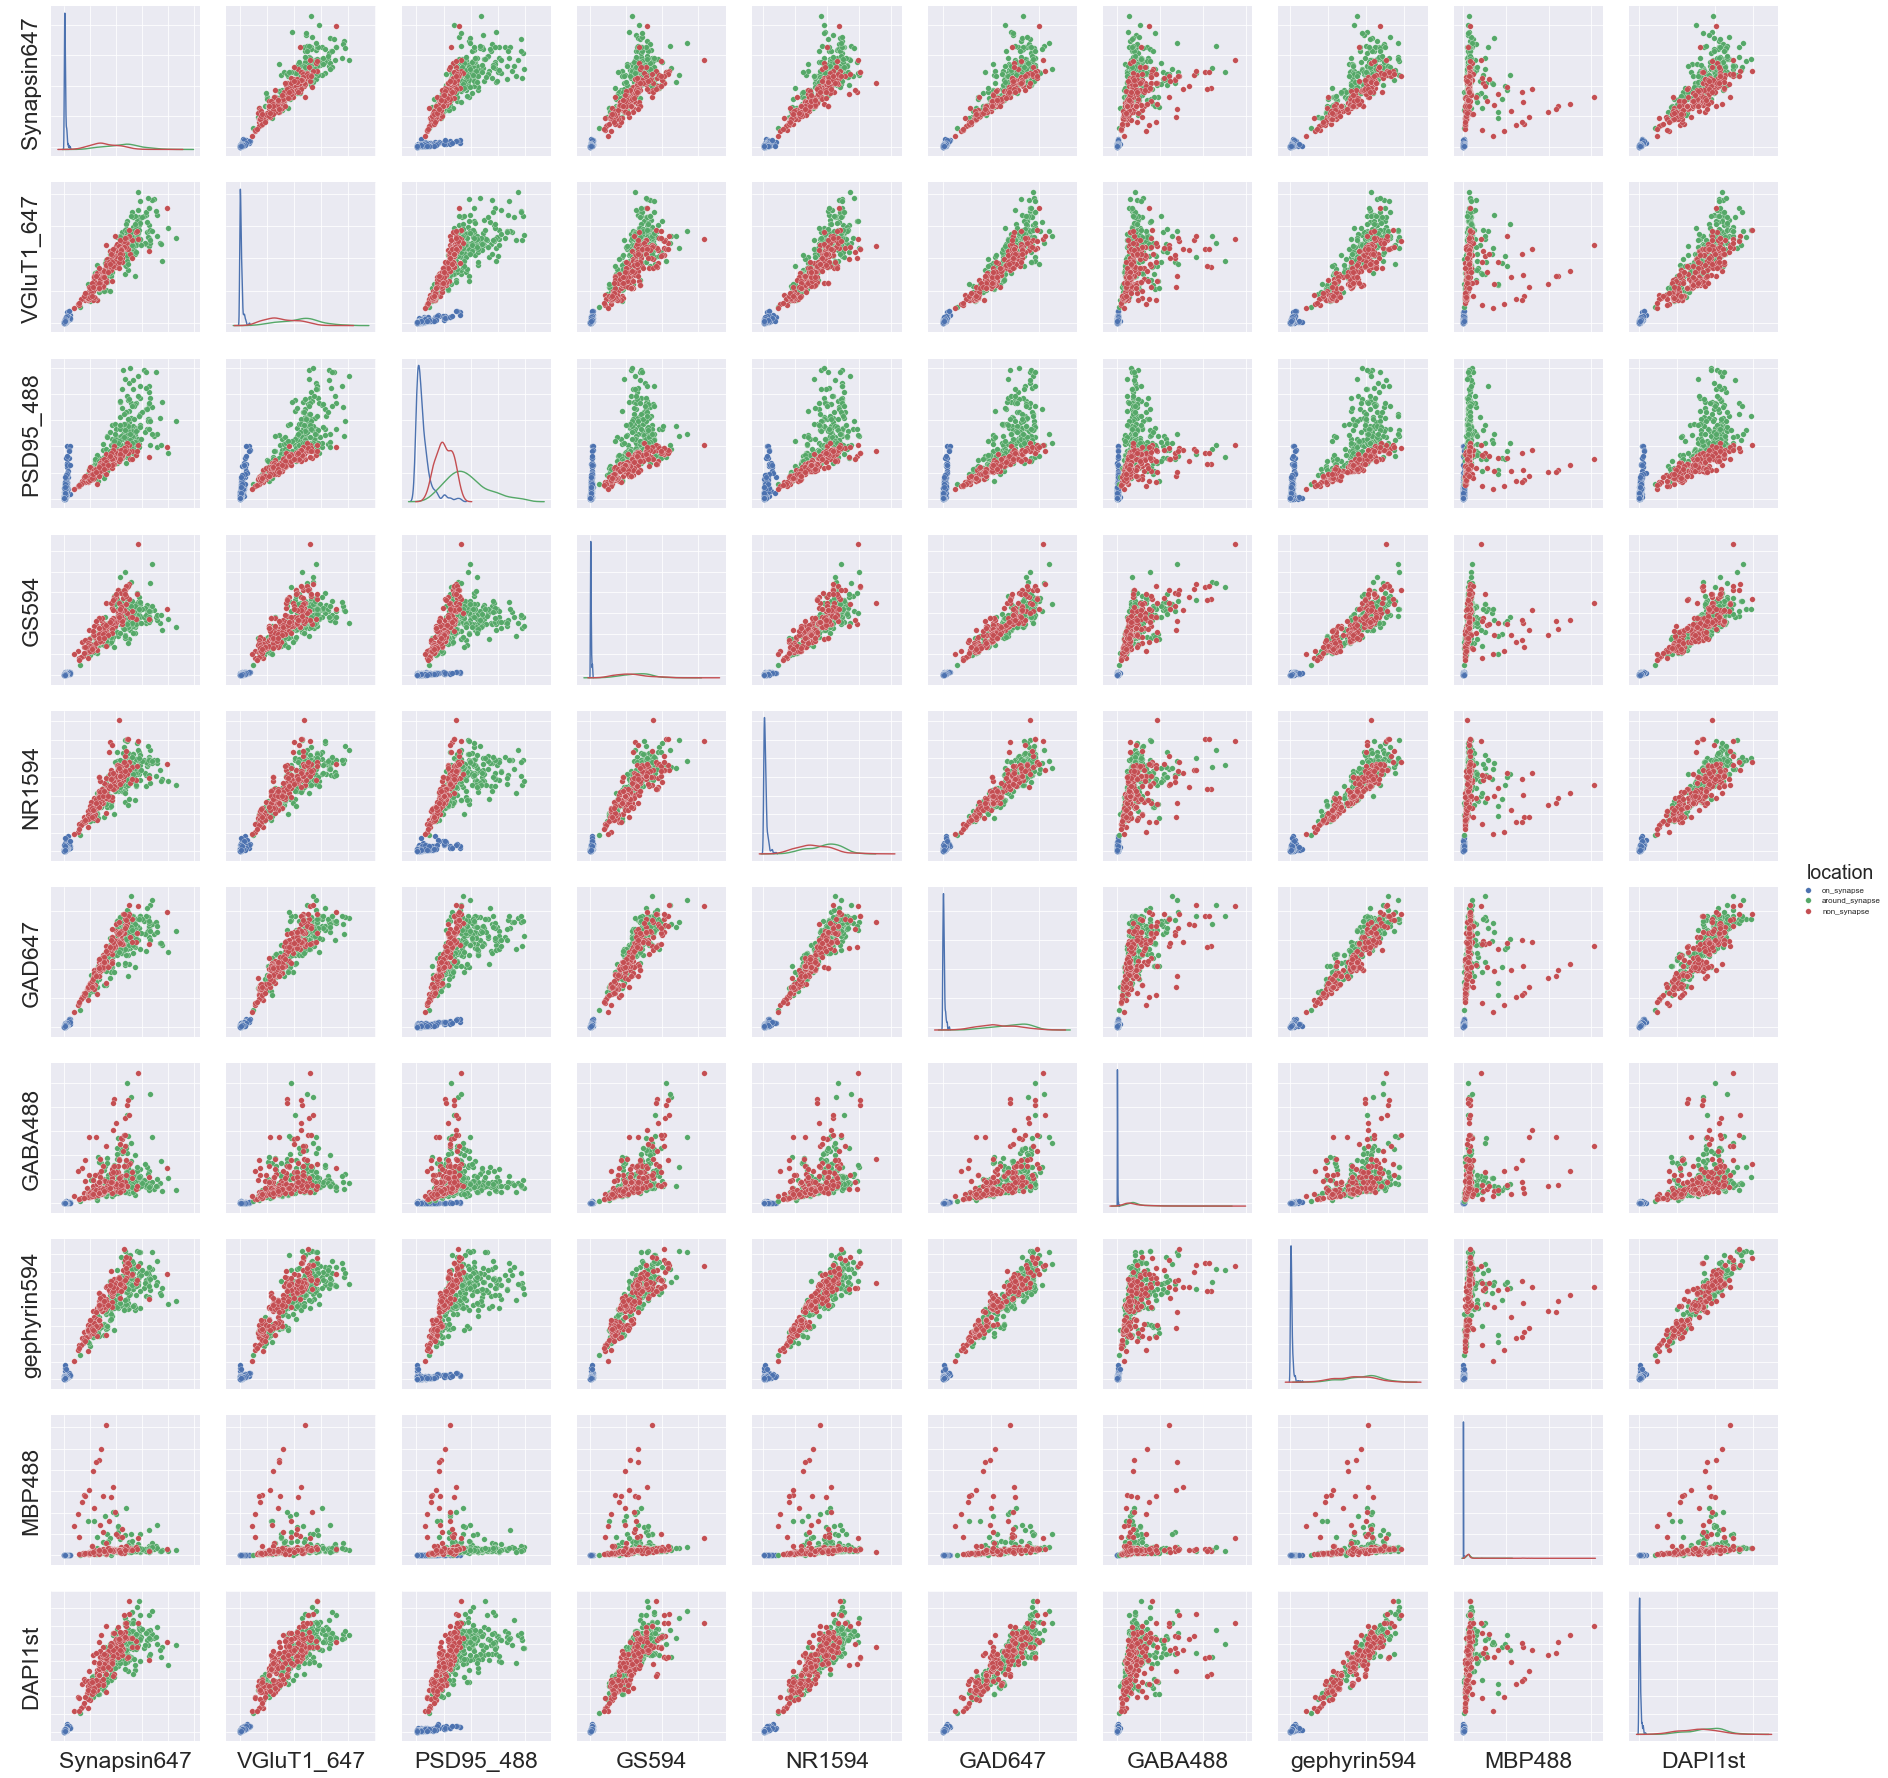

In [135]:
g = sns.pairplot(non_synapse_df[columns], hue="location", diag_kind='kde')
g.set(xticklabels=[], yticklabels=[])
g.fig

In [136]:
log_transformed_df = non_synapse_df[
[ 'Synapsin647',
    'VGluT1_647',
    'PSD95_488',
    'GS594',
    'NR1594',
    'GAD647',
    'GABA488',
    'gephyrin594',
    'MBP488',
    'DAPI1st']].transform(lambda x: np.log(x))

log_transformed_df['location'] = non_synapse_df['location']

/Users/jaewonc78/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


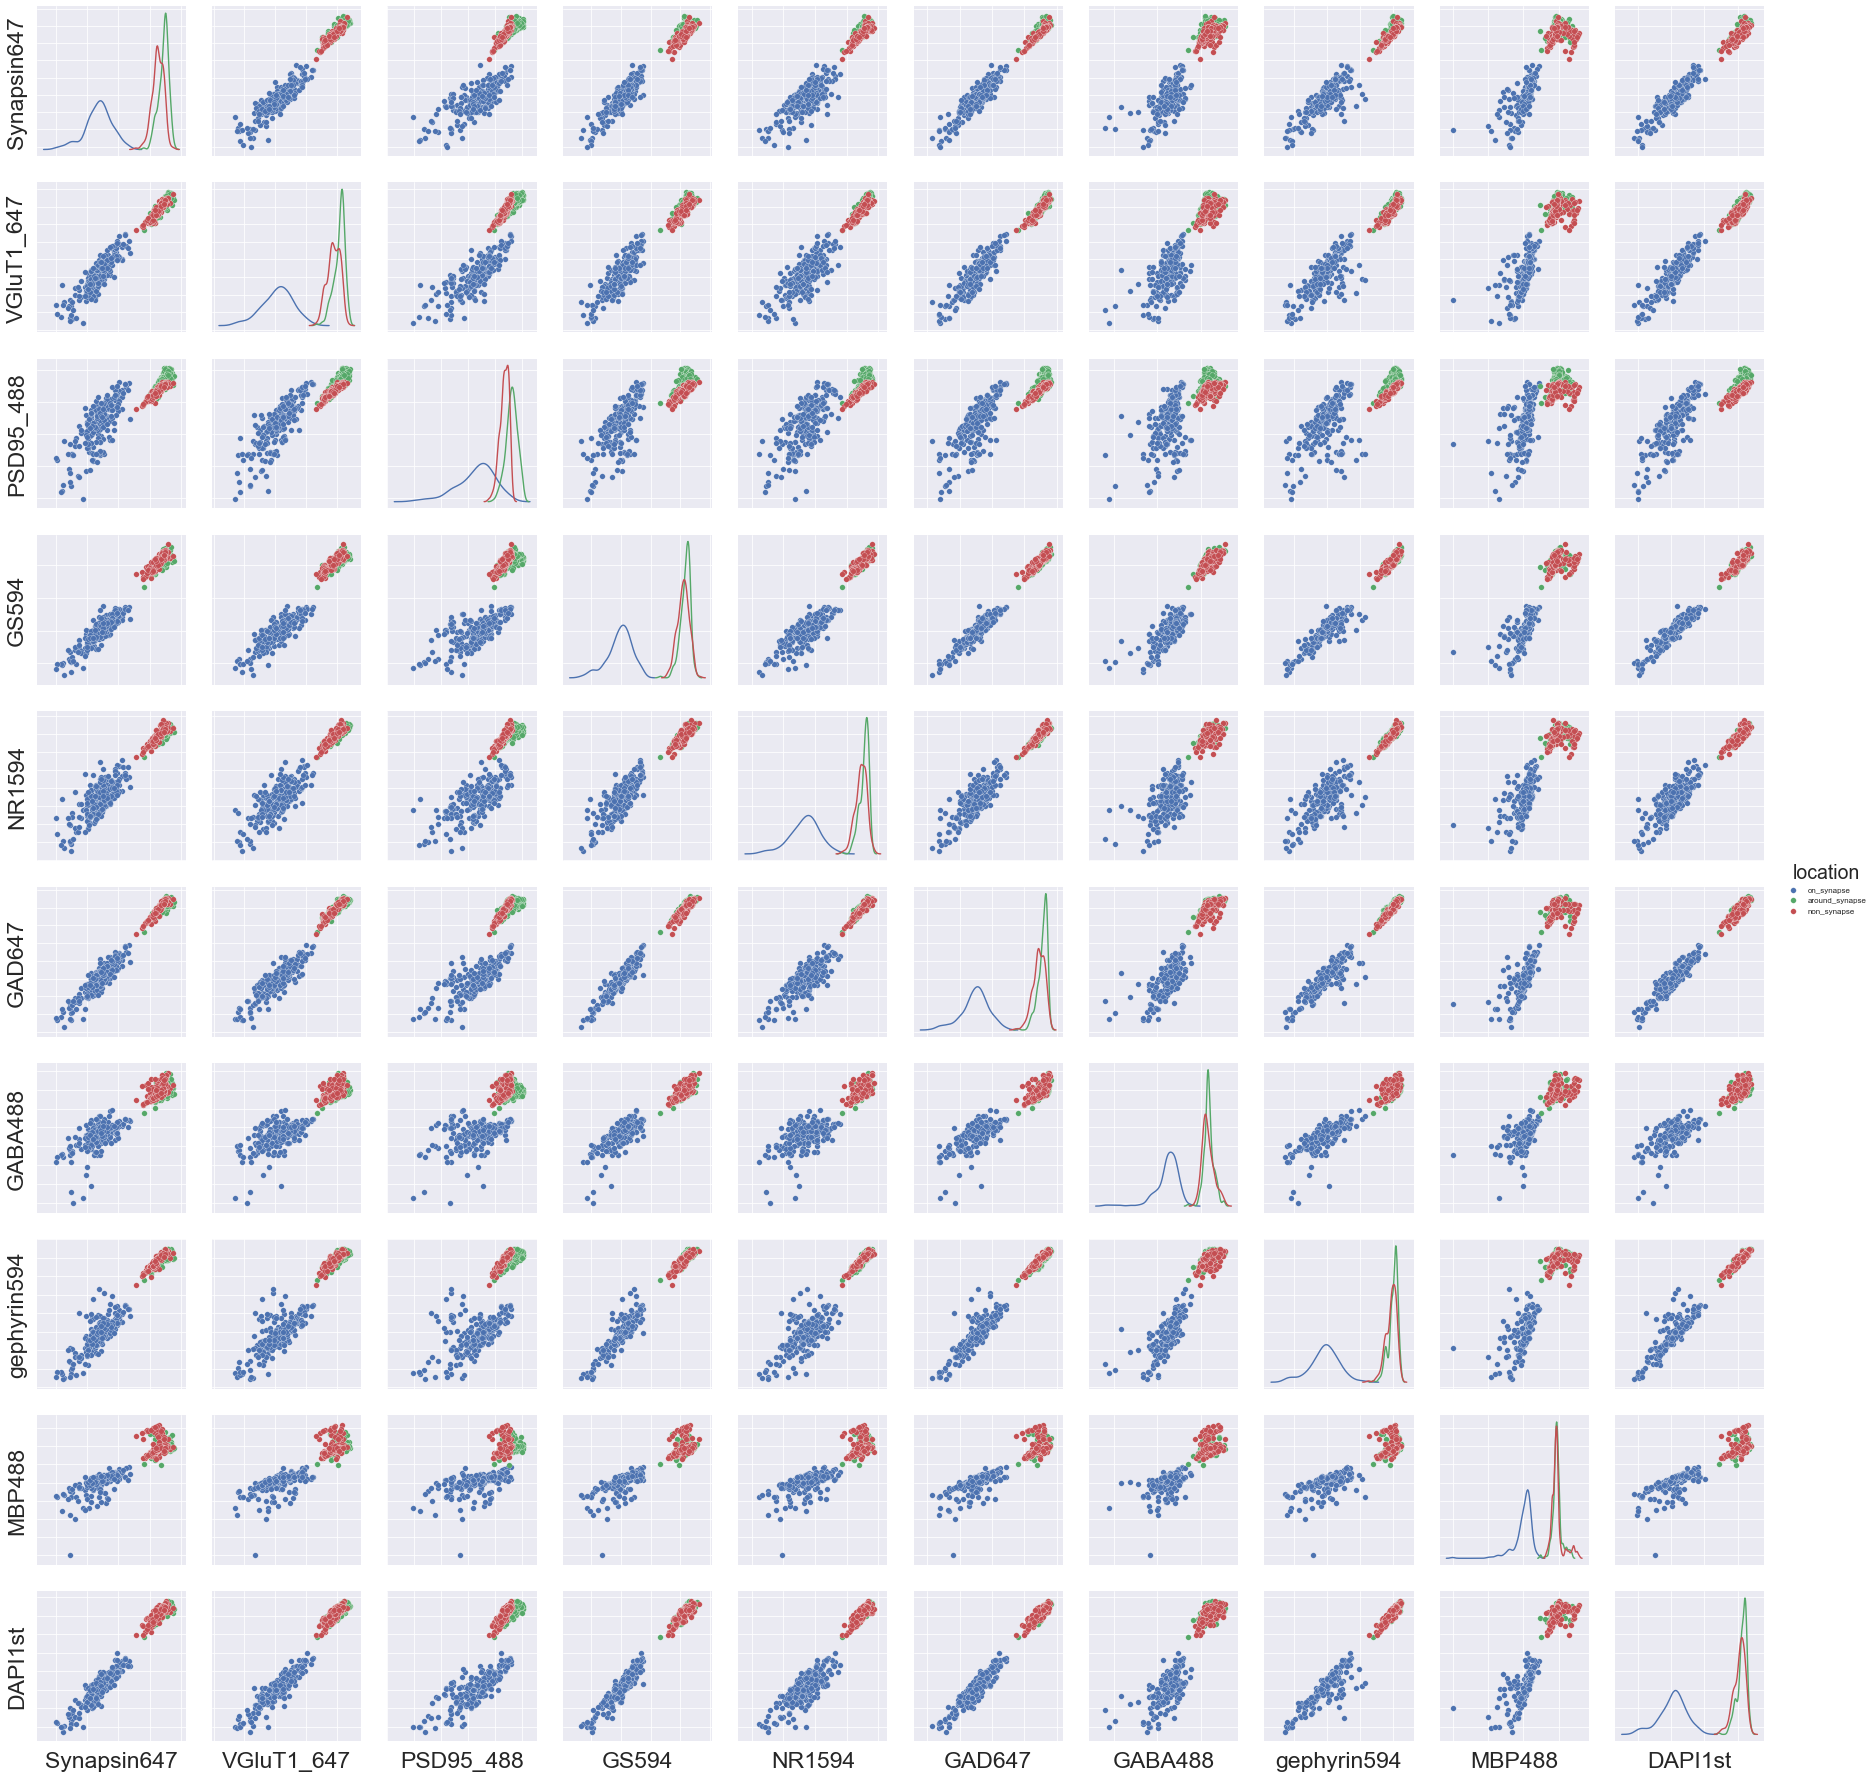

In [137]:
h = sns.pairplot(log_transformed_df[columns], hue="location", diag_kind='kde')
h.set(xticklabels=[], yticklabels=[])
h.fig

In [138]:
a, b = f0(random_non_synapse_centroids, channels, data, reduced=True)

In [140]:
non_synapse_reduced_df = pd.DataFrame(b, columns=labels)
non_synapse_reduced_df['location'] = 'non_synapse'

non_synapse_reduced_df = reduced_df.append(non_synapse_reduced_df)

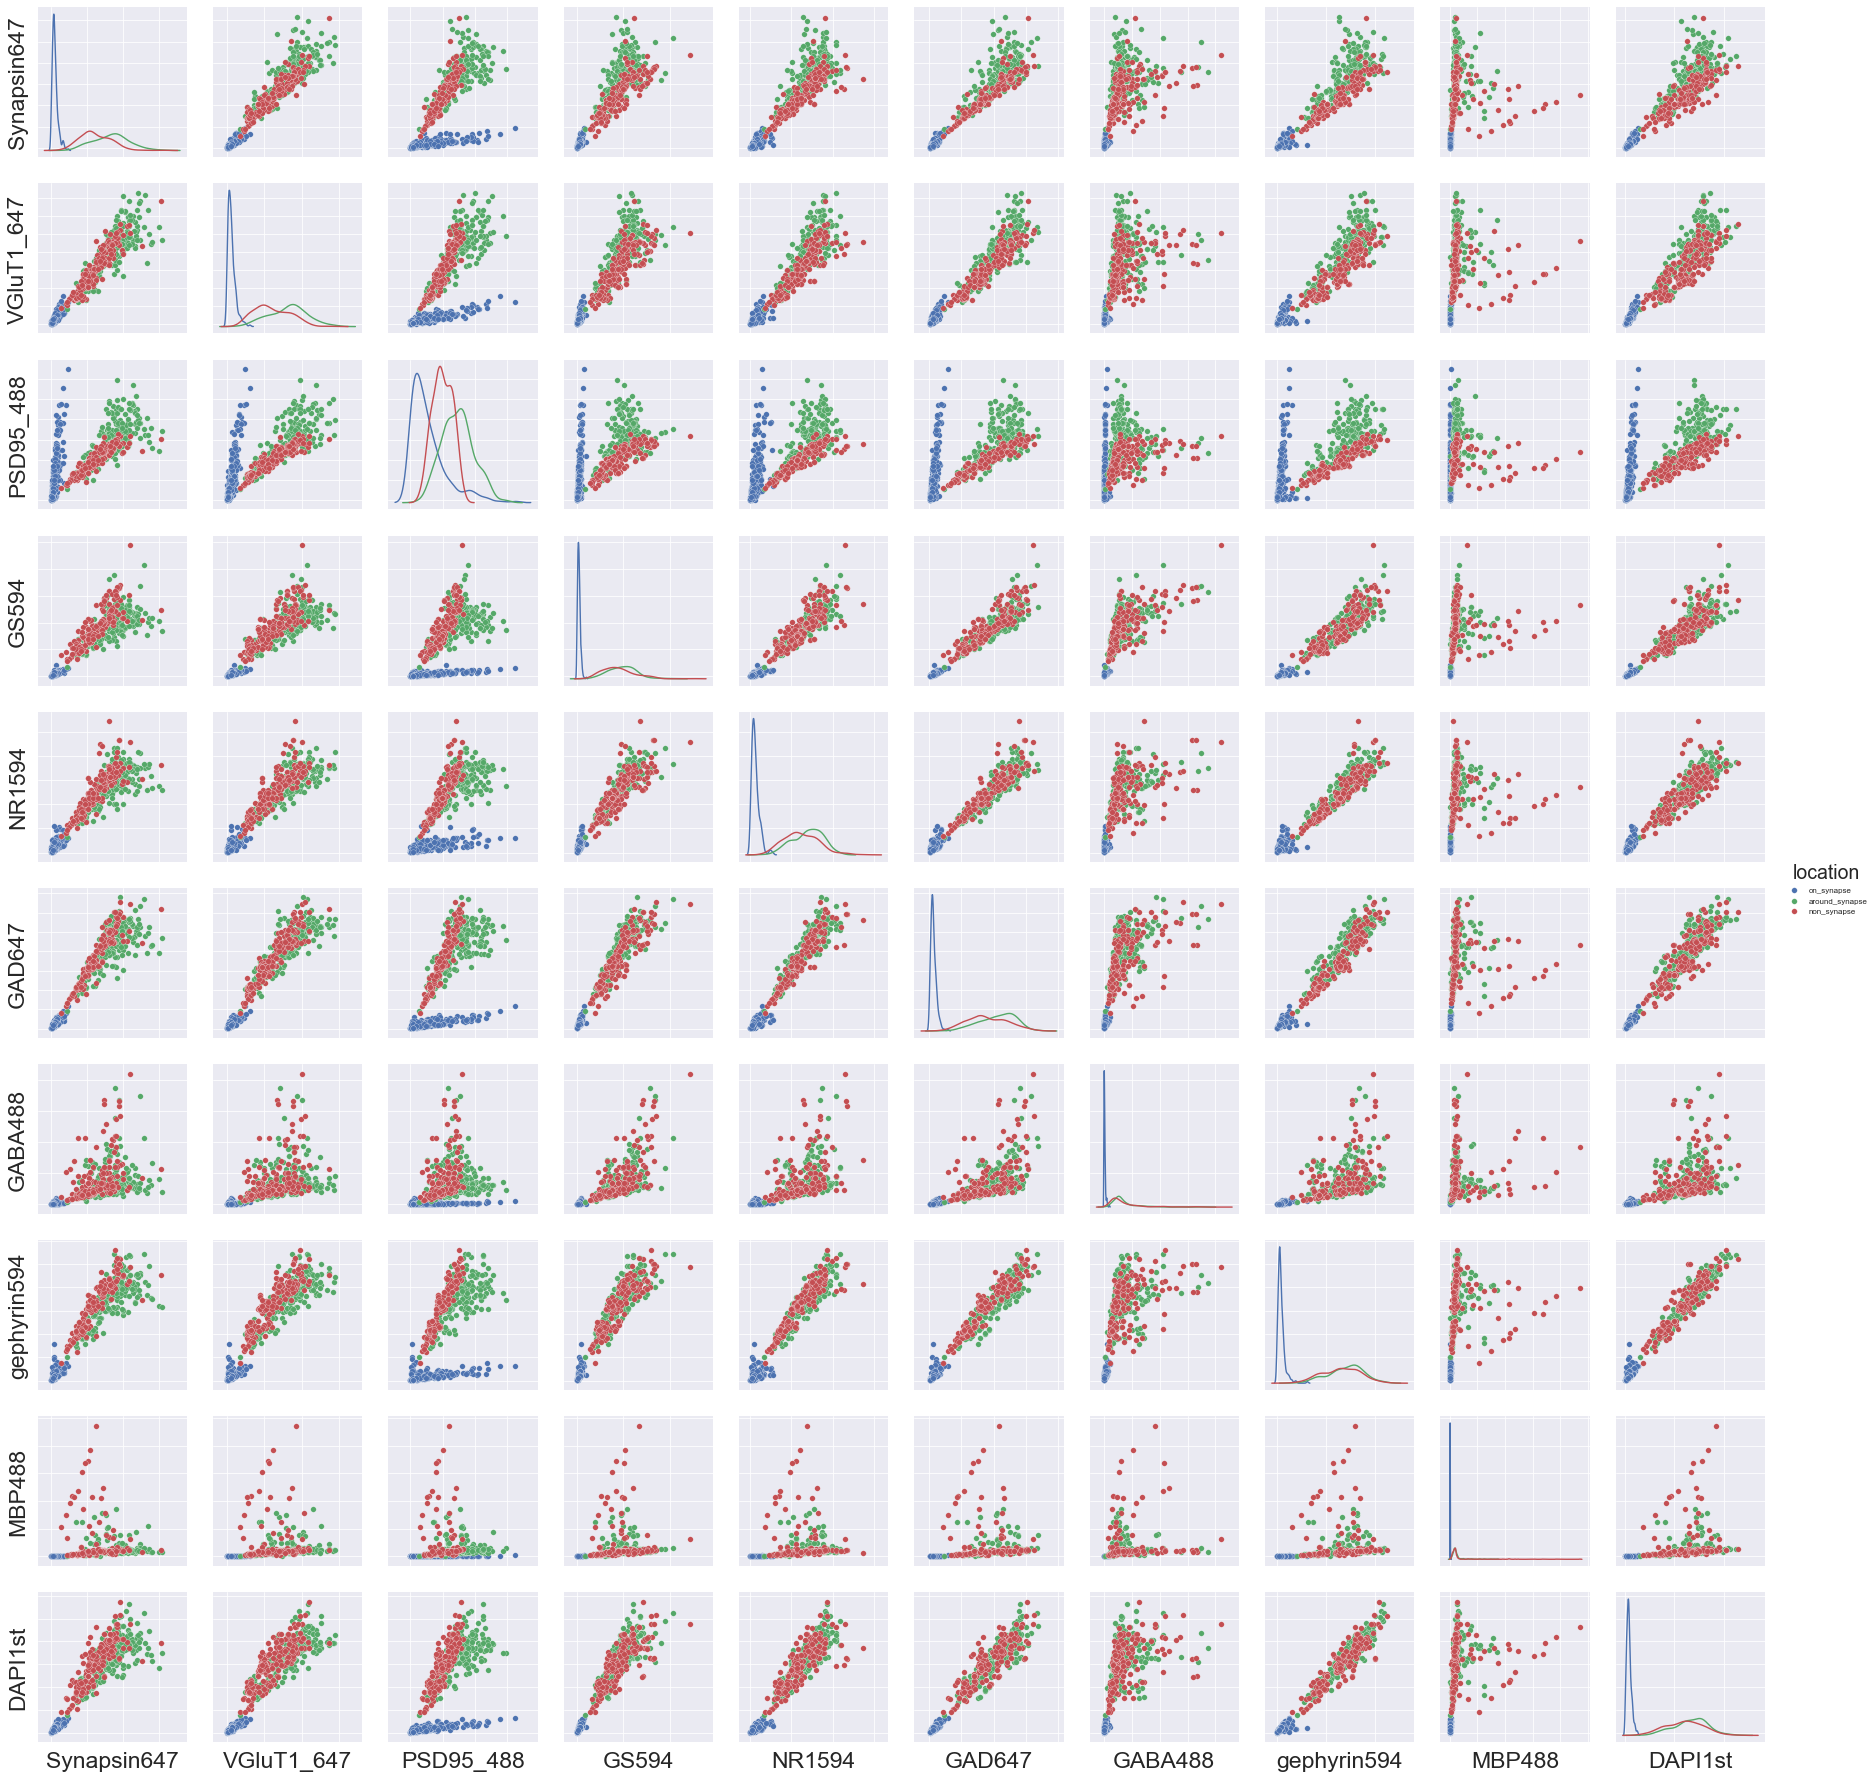

In [143]:
g = sns.pairplot(non_synapse_reduced_df[columns], hue="location", diag_kind='kde')
g.set(xticklabels=[], yticklabels=[])
g.fig

In [144]:
log_transformed_reduced_df = non_synapse_reduced_df[
[ 'Synapsin647',
    'VGluT1_647',
    'PSD95_488',
    'GS594',
    'NR1594',
    'GAD647',
    'GABA488',
    'gephyrin594',
    'MBP488',
    'DAPI1st']].transform(lambda x: np.log(x))

log_transformed_reduced_df['location'] = non_synapse_reduced_df['location']

/Users/jaewonc78/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


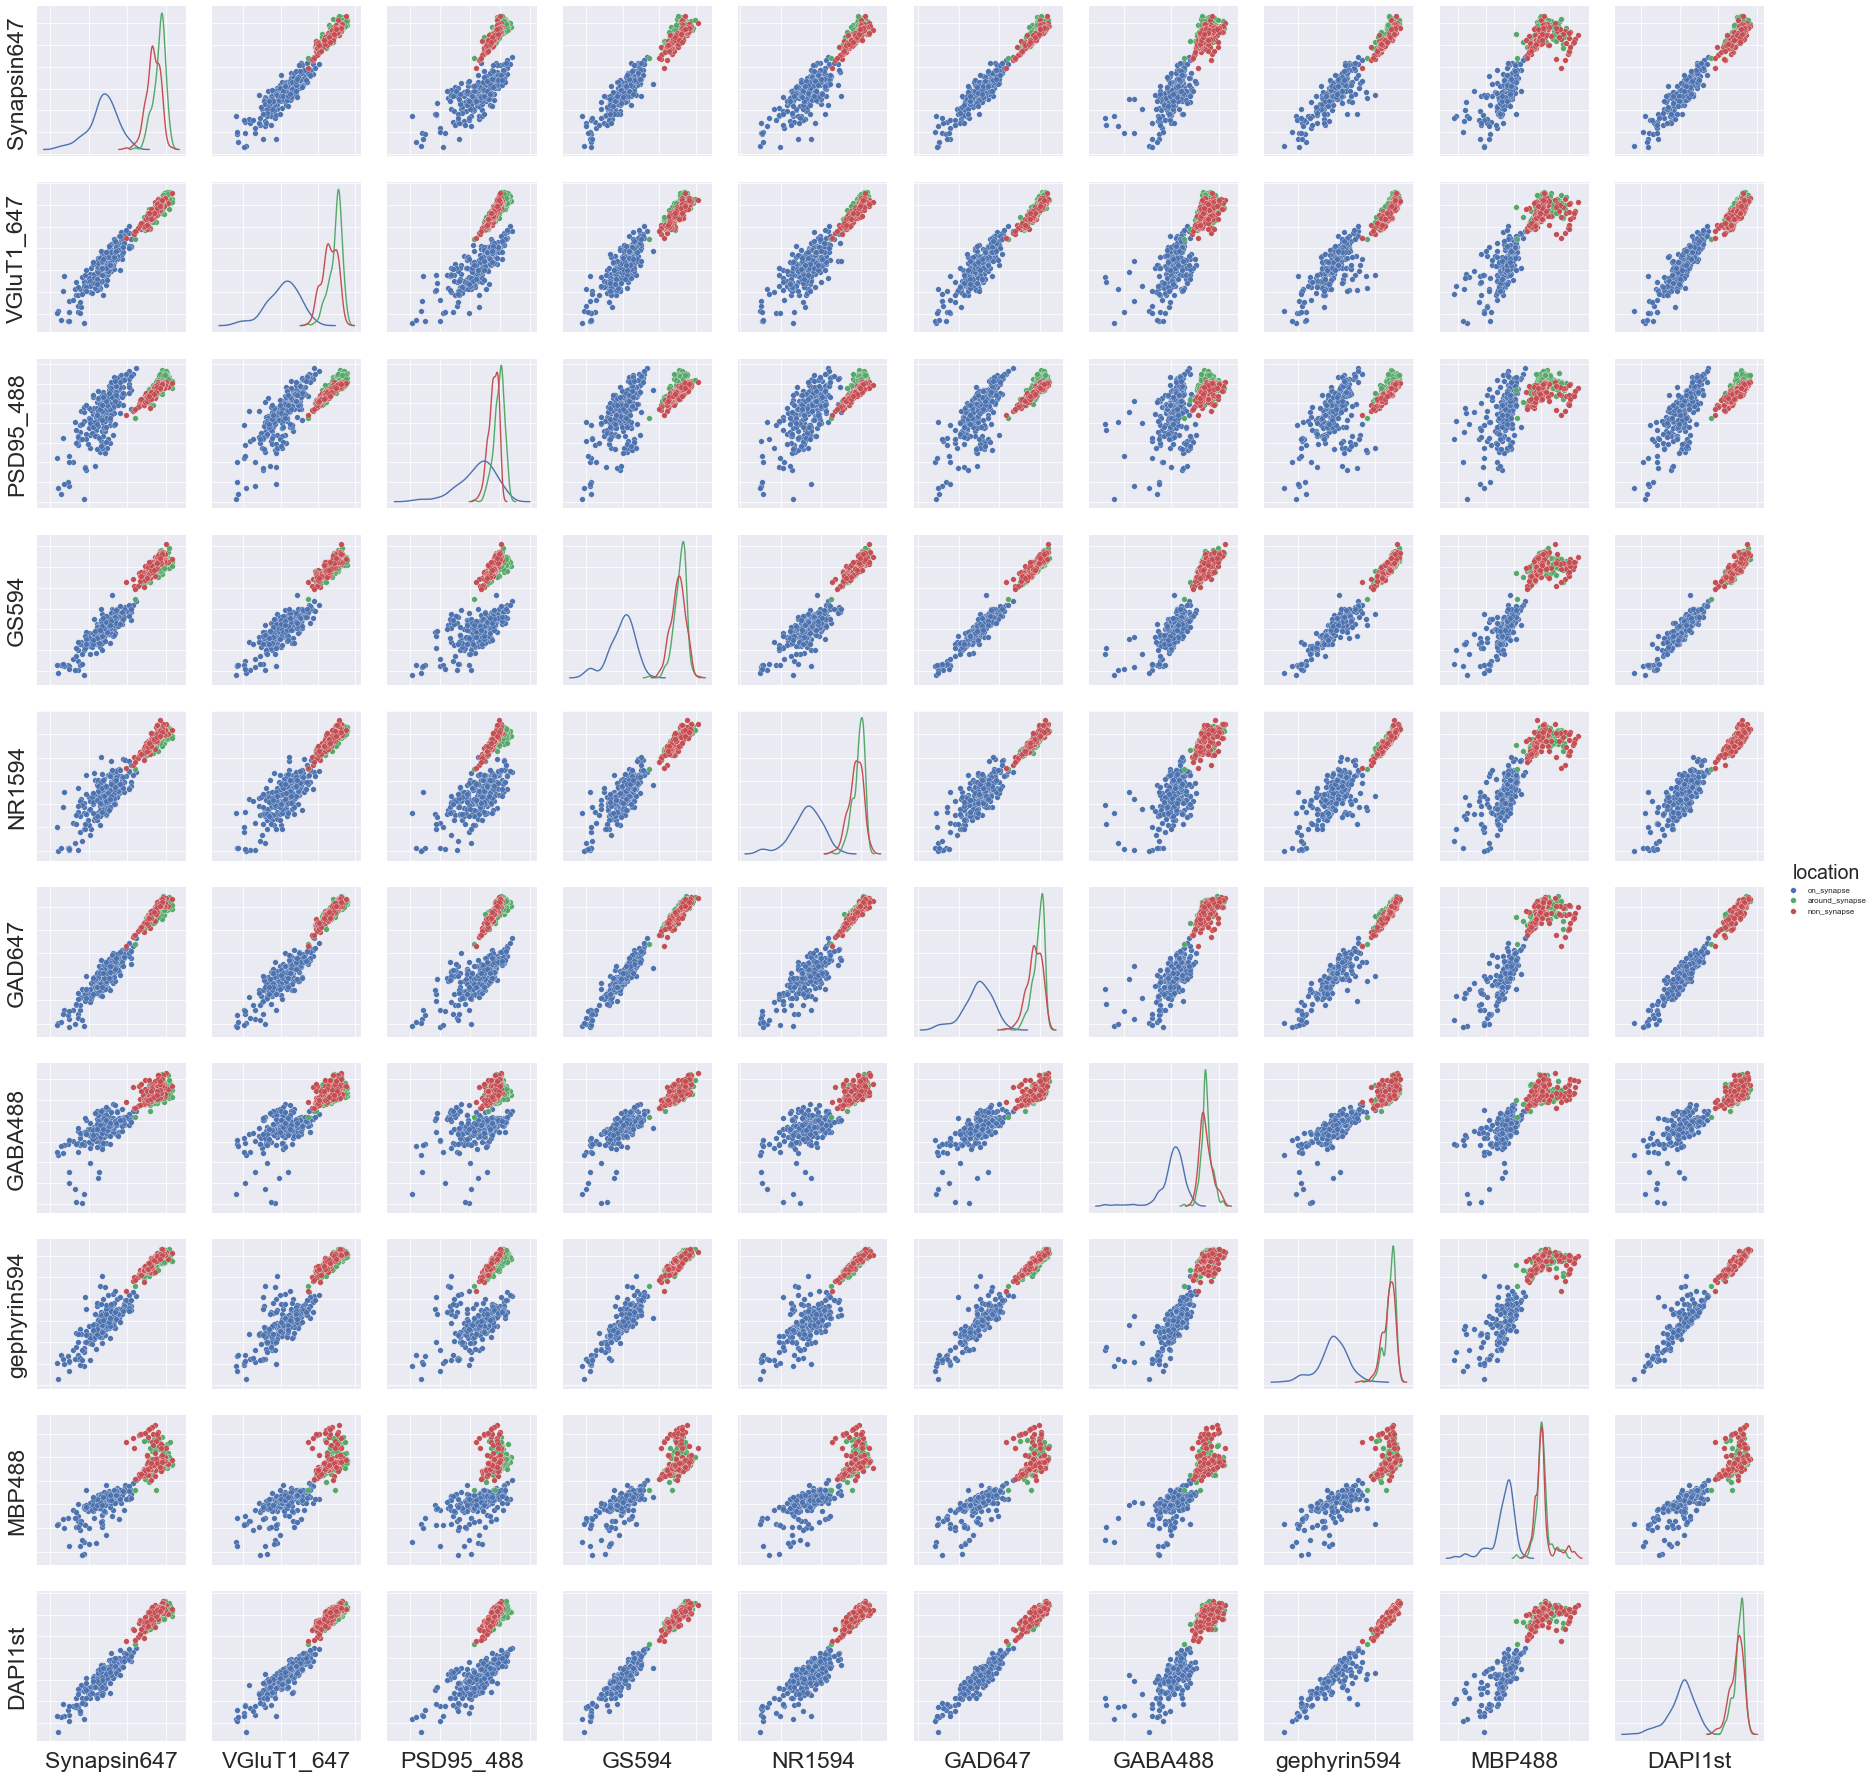

In [145]:
h = sns.pairplot(log_transformed_reduced_df[columns], hue="location", diag_kind='kde')
h.set(xticklabels=[], yticklabels=[])
h.fig